In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from raw_processing import ColumnTransformerPandas
from sklearn import set_config

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, validation_curve
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, make_scorer, roc_auc_score
from sklearn.compose import ColumnTransformer

from performance import plot_roc, plot_feature_importance
from outlier import iqr_method, reorder_cols

import altair as alt

### Generate dataset

In [2]:
cvlistdate = '21032023'
lightcurvesdate = '08102023'
label_scheme = 'labels_2'
gaia = False

pd.options.display.max_columns = None

dataset = pd.read_csv(f'../processed_data/dataset_{cvlistdate}allfeatures_inc_labels{lightcurvesdate}.csv', low_memory=False)
dataset = dataset[dataset[label_scheme].notna()].reset_index(drop=True)
# drop rows with no Gaia data
# dataset = dataset[dataset['ra_error'].notna()].reset_index(drop=True)
# dataset = dataset[dataset['absmag_g'].notna()].reset_index(drop=True)

# Drop Gaia features
dataset = dataset.iloc[:,:-34]

# Filter dataset
dataset_pts_threshold = dataset[(dataset['n_obs_g']>=20) | (dataset['n_obs_r']>=20)].reset_index(drop=True)
# dataset_timespan_threshold = dataset[dataset['temporal_baseline_g']>=365].reset_index(drop=True)

# Dataset going forward
dataset_final = dataset_pts_threshold

print(dataset_final[label_scheme].value_counts())

X = dataset_final.iloc[:,14:]
X_cols = X.columns.tolist()
y_names = dataset_final[label_scheme]
enc = LabelEncoder()
y = enc.fit_transform(y_names)


# Handle outliers
cap_cols1 = ['Period_fit_g','Period_fit_r']
cap_cols2 = ['pwr_max_g','pwr_max_r']
cap_cols3 = ['distance']

iqr_cols1 = ['LinearTrend_g','LinearTrend_r']
iqr_cols2 = ['clr_mean','clr_median', 'clr_bright','clr_faint']
iqr_cols3 = ['astrometric_sigma5d_max']
iqr_cols4 = ['bp_rp','bp_g','g_rp']
iqr_cols5 = ['absmag_g','absmag_bp','absmag_rp']

log_cols = ['Autocor_length_g','CAR_mean_g','CAR_sigma_g','Eta_e_g',
            'Freq1_harmonics_amplitude_0_g','Freq1_harmonics_amplitude_1_g',
            'Freq1_harmonics_amplitude_2_g','Freq1_harmonics_amplitude_3_g',
            'Freq2_harmonics_amplitude_0_g','Freq2_harmonics_amplitude_1_g',
            'Freq2_harmonics_amplitude_2_g','Freq2_harmonics_amplitude_3_g',
            'Freq3_harmonics_amplitude_0_g','Freq3_harmonics_amplitude_1_g',
            'Freq3_harmonics_amplitude_2_g','Freq3_harmonics_amplitude_3_g',
            'MaxSlope_g','PeriodLS_g','SlottedA_length_g',
            'Autocor_length_r','CAR_mean_r','CAR_sigma_r','Eta_e_r',
            'Freq1_harmonics_amplitude_0_r','Freq1_harmonics_amplitude_1_r',
            'Freq1_harmonics_amplitude_2_r','Freq1_harmonics_amplitude_3_r',
            'Freq2_harmonics_amplitude_0_r','Freq2_harmonics_amplitude_1_r',
            'Freq2_harmonics_amplitude_2_r','Freq2_harmonics_amplitude_3_r',
            'Freq3_harmonics_amplitude_0_r','Freq3_harmonics_amplitude_1_r',
            'Freq3_harmonics_amplitude_2_r','Freq3_harmonics_amplitude_3_r',
            'MaxSlope_r','PeriodLS_r','SlottedA_length_r'
            ]

log_cols2 = ['freq_pwr_max_g','pwr_maxovermean_g',
             'npeaks_pt5to1_g','rrate_pt5to1_g','drate_pt5to1_g', 
             'npeaks_1to2_g','rrate_1to2_g','drate_1to2_g',
             'npeaks_2to5_g','rrate_2to5_g','drate_2to5_g',
             'npeaks_above5_g','rrate_above5_g','drate_above5_g',
             'rollstd_ratio_t20s10_g','rollstd_ratio_t10s5_g',
             'pnts_leq_rollMedWin20-1mag_g','pnts_leq_rollMedWin20-2mag_g','pnts_leq_rollMedWin20-5mag_g',
             'pnts_geq_rollMedWin20+1mag_g','pnts_geq_rollMedWin20+2mag_g','pnts_geq_rollMedWin20+3mag_g',
             'pnts_leq_median-1mag_g','pnts_leq_median-2mag_g','pnts_leq_median-5mag_g',
             'pnts_geq_median+1mag_g','pnts_geq_median+2mag_g','pnts_geq_median+3mag_g',
             'freq_pwr_max_r','pwr_maxovermean_r',
             'npeaks_pt5to1_r','rrate_pt5to1_r','drate_pt5to1_r',
             'npeaks_1to2_r','rrate_1to2_r','drate_1to2_r',
             'npeaks_2to5_r','rrate_2to5_r','drate_2to5_r',
             'npeaks_above5_r','rrate_above5_r','drate_above5_r',
             'rollstd_ratio_t20s10_r','rollstd_ratio_t10s5_r',
             'pnts_leq_rollMedWin20-1mag_r','pnts_leq_rollMedWin20-2mag_r','pnts_leq_rollMedWin20-5mag_r',
             'pnts_geq_rollMedWin20+1mag_r','pnts_geq_rollMedWin20+2mag_r','pnts_geq_rollMedWin20+3mag_r',
             'pnts_leq_median-1mag_r','pnts_leq_median-2mag_r','pnts_leq_median-5mag_r',
             'pnts_geq_median+1mag_r','pnts_geq_median+2mag_r','pnts_geq_median+3mag_r'
             ]

log_cols3 = ['ra_error','dec_error',
            'parallax_error',
            'pm',
            'pmra_error',
            'pmdec_error',
            'phot_g_mean_flux',
            'phot_g_mean_flux_error',
            'phot_bp_mean_flux',
            'phot_bp_mean_flux_error',
            'phot_rp_mean_flux',
            'phot_rp_mean_flux_error',
            'distance'
            ]


log_transformer1 = FunctionTransformer(np.log1p, validate=False)
log_transformer2 = FunctionTransformer(np.log1p, validate=False)
log_transformer3 = FunctionTransformer(np.log1p, validate=False)

cap_transformer1 = FunctionTransformer(np.clip, validate=False, kw_args={'a_min':0, 'a_max':1})
cap_transformer2 = FunctionTransformer(np.clip, validate=False, kw_args={'a_min':0, 'a_max':1})
cap_transformer3 = FunctionTransformer(np.clip, validate=False, kw_args={'a_min':0, 'a_max':np.inf})

iqr_transformer1 = FunctionTransformer(iqr_method, validate=False, kw_args={'factor': 5})
iqr_transformer2 = FunctionTransformer(iqr_method, validate=False, kw_args={'factor': 2})
iqr_transformer3 = FunctionTransformer(iqr_method, validate=False, kw_args={'factor': 10})
iqr_transformer4 = FunctionTransformer(iqr_method, validate=False, kw_args={'factor': 2})
iqr_transformer5 = FunctionTransformer(iqr_method, validate=False, kw_args={'factor': 3})


if gaia == True:
    preprocessor = ColumnTransformer(
        transformers=[
            ('cap', cap_transformer1, cap_cols1),
            ('cap2', cap_transformer2, cap_cols2),
            ('cap3', cap_transformer3, cap_cols3),
            ('iqr1', iqr_transformer1, iqr_cols1),
            ('iqr2', iqr_transformer2, iqr_cols2),
            ('iqr3', iqr_transformer3, iqr_cols3),
            ('iqr4', iqr_transformer4, iqr_cols4),
            ('iqr5', iqr_transformer5, iqr_cols5),
            ('log_transform1', log_transformer1, log_cols),
            ('log_transform2', log_transformer2, log_cols2),
            ('log_transform3', log_transformer3, log_cols3)
        ],
        remainder='passthrough',  # Pass through columns not specified in transformers
        verbose_feature_names_out=False).set_output(transform='pandas'
    )
elif gaia == False:
    preprocessor = ColumnTransformer(
        transformers=[
            ('cap', cap_transformer1, cap_cols1),
            ('cap2', cap_transformer2, cap_cols2),
            ('iqr1', iqr_transformer1, iqr_cols1),
            ('iqr2', iqr_transformer2, iqr_cols2),
            ('log_transform1', log_transformer1, log_cols),
            ('log_transform2', log_transformer2, log_cols2)
        ],
        remainder='passthrough',  # Pass through columns not specified in transformers
        verbose_feature_names_out=False).set_output(transform='pandas'
    )





labels_2
dwarf_nova_SU_UMa    435
dwarf_nova_Z_Cam     168
nova_like            138
nova_like_VY_Scl     117
dwarf_nova_U_Gem     115
polar                110
int_polar             49
AMCVn                 35
nova                  27
Name: count, dtype: int64


In [3]:
# Features and labels.
X = dataset_final.iloc[:,14:]
X_cols = X.columns.tolist()
y_names = dataset_final[label_scheme]
enc = LabelEncoder().fit(y_names)
y = enc.transform(y_names)

print(X.shape)

# Train, test, split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=77)

(1194, 222)


### Define classifiers

In [5]:
rf = RandomForestClassifier(
    class_weight='balanced_subsample', 
    n_jobs=-1, 
    random_state=1,
    )

gnb = GaussianNB()

knn = KNeighborsClassifier(
    n_jobs=-1
    )

lda = LinearDiscriminantAnalysis()

xgb = XGBClassifier(
    # n_estimators=250, #250
    # max_depth=3,
    # subsample=0.8,
    # learning_rate=0.5, #0.5
    n_jobs=-1,
    random_state=1
    )

# Classifier to use.
classifier = rf
classifierNm= 'rf'
balancing = 'weights' # 'weights', 'sampling'
impute = True
norm = True
us_valid = 390
os_valid = 390
us_all = 440
os_all = 440

#### Notes

Gaussian Naive Bayes does not have a class weighting parameter. It keeps seperate records for each class, so that the common class can't interfere with the rare class and visa versa. However, clas imbalance can affect your priors p(A), p(B), etc. If the distribution of classes in your training set is not represeentative of the true distribution then generalisation may be affected.

The basic idea behind the k-NN algorithm is to find the k-nearest data points in the training set to a given test point, and then use these k-nearest data points to make a prediction about the test point.One of the main challenges with the k-NN algorithm is that it can be sensitive to class imbalance, which occurs when the number of examples in one class is significantly different from the number of examples in another class. This can cause the algorithm to be biased towards the majority class, and can lead to poor performance on the minority class.This is because the k-NN algorithm assigns the class label of the majority class to the test point if the majority of the k-nearest neighbors belong to the majority class. This can lead to the majority class dominating the predictions, even though the minority class is actually more similar to the test point.To mitigate this issue, you can use techniques like oversampling the minority class, undersampling the majority class, or using cost-sensitive learning to adjust the class weights. Additionally, you can also use ensemble methods like SMOTE and ADASYN to create synthetic samples of the minority class in the training data. In this case, I will use the Mahalanobis distance - Use a modified distance metric such as the Mahalanobis distance that takes into account the class imbalance and penalizes instances from the over-represented class.

See https://sci2s.ugr.es/keel/pdf/specific/articulo/xue_do_2008.pdf for effects of imbalanced datasets on LDA performance. It says that no significant improvement can be had from addressing class imbalance for LDA.

Implementing sample weights for XBG is done in the fit method.

### Pipeline

In [12]:
# Imputation and normalisation functions.
# Using subclassed ColumnTransformerPandas to return a Dataframe with columns instead of just an array (what is usually returned)
impute_simple = ColumnTransformerPandas([
    ('imputer', SimpleImputer(strategy='mean'), X_cols)],
    remainder='passthrough')

impute_KNN = ColumnTransformerPandas([
    ('imputer', KNNImputer(n_neighbors=5, weights='distance'), X_cols)],
    remainder='passthrough')

normalise = ColumnTransformerPandas([
    ('normalise', StandardScaler(), X_cols)], 
    remainder='passthrough')

# Under and oversampling strategies.
def sampling(us, os):
    class_dist_us = {enc.transform(['dwarf_nova_SU_UMa'])[0]:us}

    class_dist_os = {enc.transform(['dwarf_nova_SU_UMa'])[0]:os,
                     enc.transform(['dwarf_nova_Z_Cam'])[0]:os,
                     enc.transform(['dwarf_nova_U_Gem'])[0]:os,
                     enc.transform(['nova_like_VY_Scl'])[0]:os,
                     enc.transform(['polar'])[0]:os,
                     enc.transform(['nova_like'])[0]:os,
                     enc.transform(['nova'])[0]:os,
                     enc.transform(['int_polar'])[0]:os,
                     enc.transform(['AMCVn'])[0]:os
                     }

    undersample = RandomUnderSampler(sampling_strategy=class_dist_us, random_state=1)
    oversample = ADASYN(sampling_strategy=class_dist_os, n_neighbors=5,random_state=1)

    return undersample, oversample

sampled = sampling(us_valid, os_valid)
undersample = sampled[0]
oversample = sampled[1]


# Generate a pipeline to perform the column transformations sequentially.
if balancing == 'weights':
    validation_pipe = Pipeline([
        ('preprocessor', preprocessor),
        # ('reorder_cols', reorder_cols),
        ('preimpnorm', normalise),
        ('impute', impute_KNN),
        # ('us', None),
        # ('os', None),
        ('clf', classifier)
    ])
elif balancing == 'sampling':
    validation_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('reorder_cols', reorder_cols),
        ('preimpnorm', normalise),
        ('impute', impute_KNN),
        ('us', undersample),
        ('os', oversample),
        ('clf', classifier)
    ])


# If algorithm can handle missing values, do not impute.
if impute == False:
    validation_pipe.steps[1] = ('impute', None)

if norm == False:
    validation_pipe.steps[0] = ('preimpnorm', None)

# Lets display the pipeline to see the processes.
# with display='diagram', simply use display() to see the diagram
set_config(display='diagram')
display(validation_pipe)
# if desired, set display back to the default
# set_config(display='text')

# Get parameters of everything in the pipeline, including ColumnTransformer and classifier functions.
# Get all keys beginning with 'clf__' to get all the classifier parameters.
validation_pipe.get_params().keys()
[k for k in validation_pipe.get_params().keys() if k.startswith('clf__')]



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cap',
                                                  FunctionTransformer(func=<function clip at 0x105aaca30>,
                                                                      kw_args={'a_max': 1,
                                                                               'a_min': 0}),
                                                  ['Period_fit_g',
                                                   'Period_fit_r']),
                                                 ('cap2',
                                                  FunctionTransformer(func=<function clip at 0x105aaca30>,
                                                                      kw_args={'a_max': 1,
                                                                               'a_min': 0}),
                                                  ['pwr_max_g', 'pwr_max_r']),
                                                 ('iqr1',
                                                  FunctionTra...
                                                         'Freq2_harmonics_amplitude_1_g',
                                                         'Freq2_harmonics_amplitude_2_g',
                                                         'Freq2_harmonics_amplitude_3_g',
                                                         'Freq2_harmonics_rel_phase_1_g',
                                                         'Freq2_harmonics_rel_phase_2_g',
                                                         'Freq2_harmonics_rel_phase_3_g',
                                                         'Freq3_harmonics_amplitude_0_g',
                                                         'Freq3_harmonics_amplitude_1_g', ...])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        n_jobs=-1, random_state=1))])

['clf__bootstrap',
 'clf__ccp_alpha',
 'clf__class_weight',
 'clf__criterion',
 'clf__max_depth',
 'clf__max_features',
 'clf__max_leaf_nodes',
 'clf__max_samples',
 'clf__min_impurity_decrease',
 'clf__min_samples_leaf',
 'clf__min_samples_split',
 'clf__min_weight_fraction_leaf',
 'clf__n_estimators',
 'clf__n_jobs',
 'clf__oob_score',
 'clf__random_state',
 'clf__verbose',
 'clf__warm_start']

### Validation curves

[1000, 1500]


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


[CV] END .............................clf__n_estimators=1000; total time=   3.8s
[CV] END .............................clf__n_estimators=1000; total time=   3.8s
[CV] END .............................clf__n_estimators=1000; total time=   3.8s
[CV] END .............................clf__n_estimators=1500; total time=   5.7s
[CV] END .............................clf__n_estimators=1500; total time=   5.7s
[CV] END .............................clf__n_estimators=1500; total time=   5.9s
[CV] END .............................clf__n_estimators=1000; total time=   4.0s
[CV] END .............................clf__n_estimators=1000; total time=   4.0s
[CV] END .............................clf__n_estimators=1000; total time=   3.5s
[CV] END .............................clf__n_estimators=1500; total time=   5.5s


[Parallel(n_jobs=6)]: Done  10 out of  20 | elapsed:   10.0s remaining:   10.0s


[CV] END .............................clf__n_estimators=1500; total time=   5.4s
[CV] END .............................clf__n_estimators=1500; total time=   5.4s
[CV] END .............................clf__n_estimators=1000; total time=   3.7s
[CV] END .............................clf__n_estimators=1000; total time=   3.5s
[CV] END .............................clf__n_estimators=1500; total time=   5.6s
[CV] END .............................clf__n_estimators=1000; total time=   3.6s
[CV] END .............................clf__n_estimators=1500; total time=   5.7s
[CV] END .............................clf__n_estimators=1000; total time=   3.5s
[CV] END .............................clf__n_estimators=1500; total time=   4.8s
[CV] END .............................clf__n_estimators=1500; total time=   3.7s


[Parallel(n_jobs=6)]: Done  20 out of  20 | elapsed:   17.6s finished


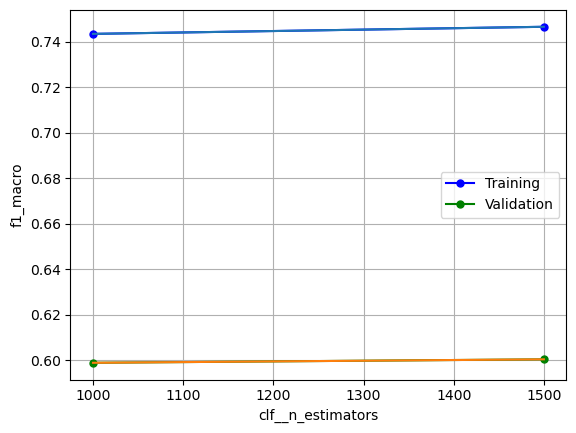

In [23]:
param_name = 'clf__n_estimators'
param_range = [1000, 1500]
 #list(range(0,1,0.05))
print(param_range)
n_jobs = 6 # max number of cores to use, -1 uses all cores - that would be 8 for me.
verbose = 2
scoring_val = make_scorer(f1_score, average='macro', zero_division=True)

train_scoreNum, test_scoreNum = validation_curve(
                                estimator=validation_pipe,
                                X=X_train, 
                                y=y_train, 
                                param_name = param_name, 
                                param_range = param_range,
                                cv = 10,
                                scoring=scoring_val,
                                verbose=verbose,
                                n_jobs=n_jobs)

train_mean = np.mean(train_scoreNum, axis=1)
test_mean = np.mean(test_scoreNum, axis=1)

# Plot the model scores (accuracy) against the paramater range
plt.plot(param_range, train_mean,
         marker='o', markersize=5,
         color='blue', label='Training')
plt.plot(param_range, test_mean,
         marker='o', markersize=5,
         color='green', label='Validation')
plt.legend()
plt.plot(param_range, train_mean)
plt.plot(param_range, test_mean)
plt.xlabel(param_name)
plt.ylabel('f1_macro')
plt.grid()
plt.show()

In [14]:
# print the mean test score along with its hyperparameter value
for i,j in zip(param_range, range(len(test_scoreNum))):
    print(i, test_scoreNum[j].mean())

# Get the best parameter value.
best_param = param_range[np.argmax(test_mean)]
print(best_param)
# 0.5 0.5884489020949648

10 0.5080760762256771
50 0.4797409780379363
100 0.47175317327302413
200 0.448959916303286
300 0.4691780696118458
400 0.47863652371585685
500 0.477160769612787
600 0.4800651163045613
700 0.4789366919328481
800 0.4802554655825242
900 0.4817418369955028
10


### Hyperparameter tuning with CV grid/randomised search

In [13]:
rf_paramgrid = {
    'clf__n_estimators': [500],
    'clf__max_depth': [6],
    'clf__min_samples_split': [19],
    'clf__max_features': [None],
    'clf__bootstrap': [True],
    'clf__class_weight': ['balanced_subsample']
}

gnb_paramgrid = {
    'clf__var_smoothing': [1e-3,1e-2,1e-1]
}

knn_paramgrid = [{
    'clf__n_neighbors': list(range(1,21,1)),
    'clf__metric': ['euclidean','manhattan','chebyshev','cosine','jaccard','hamming'], 
    'clf__weights': ['uniform', 'distance'],
    'clf__n_jobs':[-1],
    },
    {
    'clf__n_neighbors': list(range(2,21,1)),
    'clf__metric': ['minkowski'], 
    'clf__weights': ['uniform', 'distance'],
    'clf__n_jobs':[-1],
    'clf__p': [3,4]
    }
]

lda_paramgrid = [
    {
    'clf__solver': ['svd', 'lsqr'],
    'clf__shrinkage': [None]
    },
    {
    'clf__solver': ['lsqr','eigen'],
    'clf__shrinkage': ['auto'] + np.linspace(0,1,11).tolist()
    }
]

xgb_paramgrid = {
    'clf__n_estimators': [50, 100, 200, 250],
    'clf__learning_rate': [0.3, 0.4, 0.5],
    'clf__max_depth': [2,3,4],
    'clf__gamma': [0],
    'clf__subsample': [0.8],
    'clf__colsample_bytree': [1],
    'clf__n_jobs': [-1],
    'clf__random_state': [1]
}

In [14]:
# Initiaze the hyperparameters for each dictionary
params = rf_paramgrid
# Select grid search cv folds
n_folds = 10
n_iter = 100
n_jobs = 4
verbose = 2
# Scorers
scoring = {
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=True), # weighted precision
    'precision_weighted': make_scorer(precision_score, average='weighted', zero_division=True), # weighted precision
    'recall_macro': make_scorer(recall_score, average='macro'), # weighted recall
    'recall_weighted': make_scorer(recall_score, average='weighted'), # weighted recall
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=True), #'f1_weighted': 'f1_weighted'
    'f1_weighted': make_scorer(f1_score, average='weighted', zero_division=True),
}
#     'auc_macro': make_scorer(roc_auc_score, average='macro', multi_class='ovr'),
# }
# Compile GridSearchCV settings.
refit = 'f1_macro'
grid = RandomizedSearchCV(validation_pipe, params, scoring=scoring, refit=refit, cv=n_folds, n_iter=n_iter, verbose=verbose, n_jobs=n_jobs)


# Fit different models on training data
grid.fit(X_train, y_train)

# Place results in a dataframe.
cv_results = pd.DataFrame(grid.cv_results_)


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END clf__bootstrap=True, clf__class_weight=balanced_subsample, clf__max_depth=6, clf__max_features=None, clf__min_samples_split=19, clf__n_estimators=500; total time=  14.5s
[CV] END clf__bootstrap=True, clf__class_weight=balanced_subsample, clf__max_depth=6, clf__max_features=None, clf__min_samples_split=19, clf__n_estimators=500; total time=  14.6s
[CV] END clf__bootstrap=True, clf__class_weight=balanced_subsample, clf__max_depth=6, clf__max_features=None, clf__min_samples_split=19, clf__n_estimators=500; total time=  14.6s
[CV] END clf__bootstrap=True, clf__class_weight=balanced_subsample, clf__max_depth=6, clf__max_features=None, clf__min_samples_split=19, clf__n_estimators=500; total time=  14.6s
[CV] END clf__bootstrap=True, clf__class_weight=balanced_subsample, clf__max_depth=6, clf__max_features=None, clf__min_samples_split=19, clf__n_estimators=500; total time=  14.8s
[CV] END clf__bootstrap=True, clf__class_wei

### Use best parameters to generate a model

In [15]:

# cv_results.to_csv(f'../results/test_cv_results_{classifierNm}_{balancing}_dataset{cvlistdate}_lcset{lightcurvesdate}.csv')

best_metric = 'f1_macro'
best_params = cv_results.sort_values(by=f'rank_test_{best_metric}', ascending=True).iloc[0,:]['params']
cv_std = cv_results.sort_values(by=f'rank_test_{best_metric}', ascending=True).iloc[0,:]['std_test_f1_macro']
cv_score =  cv_results.sort_values(by=f'rank_test_{best_metric}', ascending=True).iloc[0,:]['mean_test_f1_macro']
print(f'Best parameters: {best_params} \nCV score: {cv_score} \nCV std: {cv_std}')


Best parameters: {'clf__n_estimators': 500, 'clf__min_samples_split': 19, 'clf__max_features': None, 'clf__max_depth': 6, 'clf__class_weight': 'balanced_subsample', 'clf__bootstrap': True} 
CV score: 0.6311520458347253 
CV std: 0.05025605822057831


In [17]:
# Remove the clf__ prefix from the keys
best_params = {k.replace('clf__', ''):v for k,v in best_params.items()}

test_params = {
    'clf__metric': 'nan_euclidean',
    'clf__n_jobs':-1,
    'clf__n_neighbors': 10
}
test_params = {k.replace('clf__', ''):v for k,v in test_params.items()}

random_state = 1

clf_best_params = classifier.set_params(**best_params)

# Under and oversampling strategies.
sampled2 = sampling(us_all,os_all)
undersample2 = sampled2[0]
oversample2 = sampled2[1]

# Use those to train a new model using the whole trianing set.
# Generate a pipeline to perform the column transformations sequentially.
if balancing == 'sampling':
    pipe2 = Pipeline([
        ('preprocessor', preprocessor),
        # ('reorder_cols', reorder_cols),
        ('preimpnorm', normalise),
        ('impute', impute_KNN),
        ('us', undersample2),
        ('os', oversample2),
        ('normalise', None),
        ('clf', clf_best_params)
    ])
elif balancing == 'weights':
    pipe2 = Pipeline([
        ('preprocessor', preprocessor),
        # ('reorder_cols', reorder_cols),
        ('preimpnorm', normalise),
        ('impute', impute_KNN),
        # ('us', None),
        # ('os', None),
        # ('normalise', None),
        ('clf', clf_best_params)
    ])

# If algorithm can handle missing values, do not impute.
if impute == False:
    pipe2.steps[1] = ('impute', None)

if norm == False:
    validation_pipe.steps[0] = ('preimpnorm', None)


best_model = pipe2.fit(X_train, y_train)

[[ 3  6  1  1  0  0  0  0  0]
 [ 4 93 10 17  0  2  3  0  2]
 [ 0 10 19  5  0  0  1  0  0]
 [ 1  3  6 29  1  1  5  1  3]
 [ 0  0  3  1  4  0  3  3  1]
 [ 0  1  0  0  0  6  0  0  1]
 [ 0  0  0  9  2  1 26  1  2]
 [ 0  1  0  2  0  1  0 28  3]
 [ 1  1  4  3  0  2  3  5 14]]
                   precision  recall  f1-score  support
AMCVn                   0.33    0.27      0.30       11
dwarf_nova_SU_UMa       0.81    0.71      0.76      131
dwarf_nova_U_Gem        0.44    0.54      0.49       35
dwarf_nova_Z_Cam        0.43    0.58      0.50       50
int_polar               0.57    0.27      0.36       15
nova                    0.46    0.75      0.57        8
nova_like               0.63    0.63      0.63       41
nova_like_VY_Scl        0.74    0.80      0.77       35
polar                   0.54    0.42      0.47       33
accuracy                0.62    0.62      0.62        0
macro avg               0.55    0.55      0.54      359
weighted avg            0.64    0.62      0.62      359


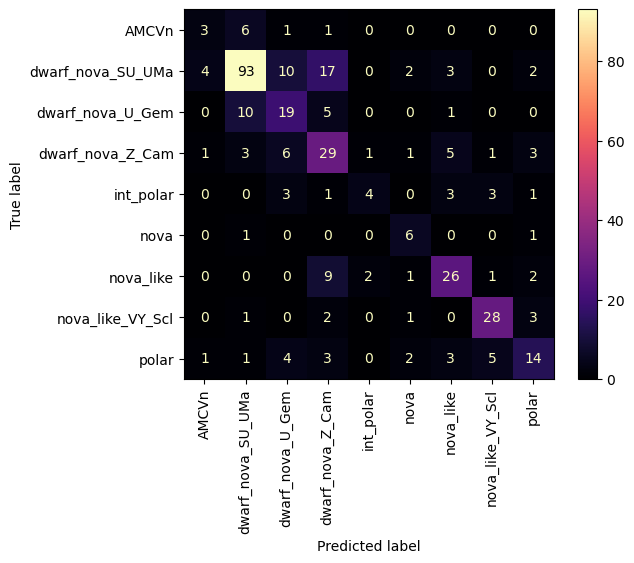

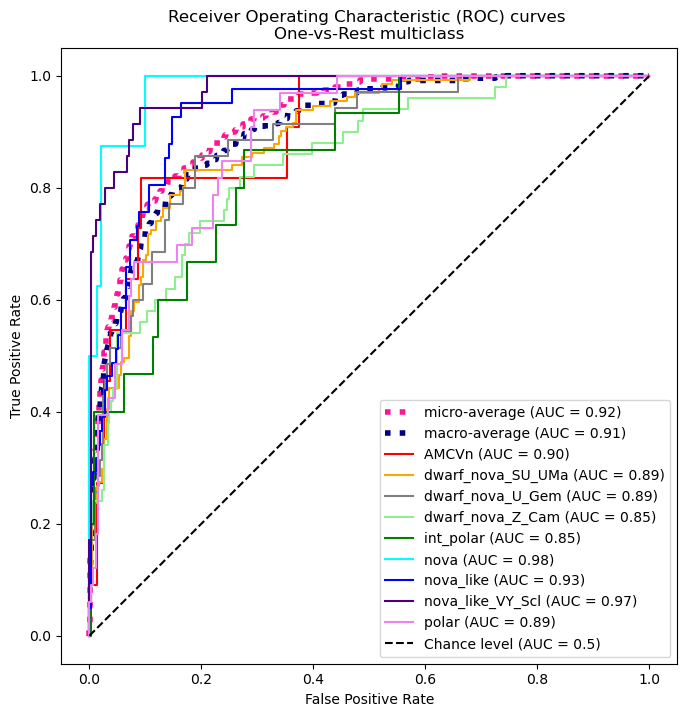

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from matplotlib import pyplot as plt
import seaborn as sns

# # Store best parameters and best model in variables.
# best_params = grid.best_params_
# best_model = grid.best_estimator_
# print(best_params)

experiment = 'test'


# Collect unique class labels in order of y_test.
class_labels = enc.inverse_transform(np.unique(y_test))


# Make predictions and gather probabilities for applying model to test set.
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)


# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(cm, display_labels=class_labels)
disp.plot(xticks_rotation='vertical', cmap='magma')
# disp.figure_.savefig(f'../results/{experiment}_cm_{classifierNm}_{balancing}.pdf', format='pdf', bbox_inches='tight')
print(cm)


# Plot roc one vs rest curves
# plot_roc(y_train, y_test, y_prob, enc, path=f'class_balance/roc_{refit}_{classifierNm}_{label_scheme}.pdf')


# Print and save the classification report
cr = classification_report(y_test, y_pred, target_names=class_labels, output_dict=True, zero_division=0)
cr_df = pd.DataFrame(cr).transpose().round({'precision':2, 'recall':2, 'f1-score':2}).astype({'support':'int64'})
# cr_df.to_csv(f'../results/{experiment}_cr_{classifierNm}_{balancing}.csv')
print(cr_df)

# try:
#     feature_importance_scores = best_model.named_steps['clf'].feature_importances_
#     plot_feature_importance(importance=feature_importance_scores, 
#                             names=X_cols, model_type='RANDOM FOREST', top_n=20, path=f'../results/feature_importance/{experiment}_feature_importance_{classifierNm}_{balancing}.pdf')
# except:
#     pass

plot_roc(y_train, y_test, y_prob, enc, path=f'../results/roc_curve/rftest.pdf')

In [19]:
# save the model and class labels and best parameters using pickle
import pickle
pickle.dump(best_model, open(f'../results/model/model_{classifierNm}_{balancing}_datasetdate{cvlistdate}_lcdate{lightcurvesdate}.pkl', 'wb'))
# pickle.dump(best_params, open(f'../results/best_params/test_best_params_{classifierNm}_{balancing}.pkl', 'wb'))
# pickle.dump(enc, open(f'../results/encoder/test_encoder_{classifierNm}_{balancing}.pkl', 'wb'))

In [20]:
import ugtm
# Preliminaries
# If you try to create a plot that will directly embed a dataset with more than 5000 rows, you will see a MaxRowsError:
# This is not because Altair cannot handle larger datasets, but it is because it is important for the user to think carefully 
# about how large datasets are handled. As noted above in Why does Altair lead to such extremely large notebooks?, 
# it is quite easy to end up with very large notebooks if you make many visualizations of a large dataset, and this error 
# is a way of preventing that.
# If you are certain you would like to embed your dataset within the visualization specification, you can disable the 
# MaxRows check with the following:
mod = best_model

alt.data_transformers.disable_max_rows()


# These are all our class probabilities from our original model.
labels2 = enc.classes_.tolist()
preds_train = mod.predict_proba(X_train)
preds_test = mod.predict_proba(X_test)

# Let's add some column names.
preds_train_df = pd.DataFrame()
for count, name in enumerate(labels2):
    preds_train_df[name] = preds_train[:,count]

preds_test_df = pd.DataFrame()
for count, name in enumerate(labels2):
    preds_test_df[name] = preds_test[:,count]


scaler = StandardScaler().fit(preds_train_df)
preds_train_df = scaler.transform(preds_train_df)
preds_test_df = scaler.transform(preds_test_df)

data = preds_train_df
y_set = y_train
X_set = X_train

gtm_model = ugtm.runGTM(data,verbose=False,k=12, niter=2000)

# Use the following if you want to see the projections of the test data onto the latent space.
transformed=ugtm.transform(optimizedModel=gtm_model,train=data,test=preds_test_df)

# mean projection
# mean position of each data point in latent space.
# Further information located here: https://ugtm.readthedocs.io/en/latest/ugtm.html?highlight=ugtm.matY#module-ugtm.ugtm_classes/
# For projection of test data use: mean_u = transformed.matMeans, otherwise use:
mean_u = gtm_model.matMeans

mean_u = pd.DataFrame(mean_u, columns=['U1','U2'])

# Add the labels to the latent space. Since we are using the training data, we use y_train.
mean_u_labels = mean_u.copy()
mean_u_labels['y'] = enc.inverse_transform(y_train)

# # May also use. Actually you can't as this is just a scikit learn wrapper and does not contain the methods of the above.
# gtm_model2 = eGTM(k=10,verbose=False).fit(data).transform(data)
# mean_u2 = pd.DataFrame()
# mean_u2['U1'] = gtm_model2[:,0]
# mean_u2['U2'] = gtm_model2[:,1]

# Plot the latent space. But do so with a combination of different shapes and colours.

alt.Chart(mean_u_labels).mark_point(size=40).encode(
    x='U1', 
    y='U2',
    color= 'y',
    shape='y',
    tooltip=['y']
    ).interactive()




alt.Chart(...)

In [21]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

# matY has shape n_dimensions (number of features) * n_nodes in latent space. 
# Manifold in n-dimensional space (projection of matX in data space); 
# A point matY[:,i] is a center of a Gaussian component i on the manifold in data space. Y=WΦT
# Location of each node in the high dimensional space.
# It is related to the actual probability space through Y=W*phi(transpose).
# We therefore need to normalise the matrix to show the strength of a node's association to a given class relative to the other nodes.
refvect = gtm_model.matY
print(refvect.shape)

refvect = scaler.inverse_transform(refvect.T).T
# refvect = MinMaxScaler().fit_transform(refvect.T).T



# Here we are plotting matX, the coordinates of the nodes in the 2D space. We will colour code them based on 'label'. So this will be a
# grid of pixels in 2D space that is colour coded by some parameter.
def plot_ref_vect(gtm_matX,label,title,fig_size=(200,200)):
    dfmap = pd.DataFrame(gtm_matX, columns=["x1", "x2"])
    dfmap['Prob'] = label
    map = alt.Chart(dfmap).mark_square().encode(
        x='x1',
        y='x2',
        color=alt.Color('Prob:Q',
                        #scale=alt.Scale(scheme='viridis')),
                        scale=alt.Scale(scheme='turbo')),
        size=alt.value(325),
        tooltip=['x1','x2', 'Prob:Q'],
        #opacity='density'
    ).properties(title = title, width = fig_size[0], height = fig_size[1])
    return map
# %%

# Here we save into variables plots for each of the classes. The colour coding is based on matY. matY defines the central
# position of each Gaussian (node) in feature, or in this case class probability, space. 
gtm_refvect0 = plot_ref_vect(gtm_model.matX,label=refvect[0,:],title=labels2[0])
gtm_refvect1 = plot_ref_vect(gtm_model.matX,label=refvect[1,:],title=labels2[1])
gtm_refvect2 = plot_ref_vect(gtm_model.matX,label=refvect[2,:],title=labels2[2])
gtm_refvect3 = plot_ref_vect(gtm_model.matX,label=refvect[3,:],title=labels2[3])
gtm_refvect4 = plot_ref_vect(gtm_model.matX,label=refvect[4,:],title=labels2[4])
gtm_refvect5 = plot_ref_vect(gtm_model.matX,label=refvect[5,:],title=labels2[5])
gtm_refvect6 = plot_ref_vect(gtm_model.matX,label=refvect[6,:],title=labels2[6])
gtm_refvect7 = plot_ref_vect(gtm_model.matX,label=refvect[7,:],title=labels2[7])
gtm_refvect8 = plot_ref_vect(gtm_model.matX,label=refvect[8,:],title=labels2[8])

gtm_refs_top = gtm_refvect0 |  gtm_refvect1 |  gtm_refvect2 
gtm_refs_middle = gtm_refvect3 | gtm_refvect4 | gtm_refvect5
gtm_refs_bottom = gtm_refvect6 | gtm_refvect7 | gtm_refvect8 
class_maps = alt.vconcat(gtm_refs_top, gtm_refs_middle, gtm_refs_bottom).configure_legend(labelFontSize=15,titleFontSize=17, titleFontWeight='normal').configure_axis(labelFontSize=0, titleFontSize=15, titleFontWeight='normal')
class_maps = class_maps.configure_title(fontSize=18,fontWeight='bold')

class_maps

(9, 144)


alt.VConcatChart(...)